In [1]:
import faiss
import numpy as np

In [2]:
index = faiss.read_index('Image1MIVF.index')

In [3]:
vectors = []
index.ntotal

1000000

In [4]:
for i in range(index.ntotal):
    # print(type((index.reconstruct(i))))
    # print(len((index.reconstruct(i))))
    vectors.append(index.reconstruct(i))

In [5]:
len(vectors)
vectors = np.array(vectors)
print(vectors.shape)
print(type(vectors[0][0]))

(1000000, 1152)
<class 'numpy.float32'>


In [6]:
import time

In [8]:
start_time = time.time()
index_flatl2 = faiss.IndexFlatL2(vectors.shape[1])
index_flatl2.add(vectors)
print("Time taken to create IndexFlatL2: %.2f seconds" % (time.time() - start_time))

Time taken to create IndexFlatL2: 3.19 seconds


In [7]:
start_time = time.time()

nlist = 50 # number of Voronoi cells (i.e., clusters)
kmeans = faiss.Kmeans(vectors.shape[1], nlist)
kmeans.train(vectors)

quantizer = faiss.IndexFlatL2(vectors.shape[1])
quantizer.add(kmeans.centroids)

index_ivfflat = faiss.IndexIVFFlat(quantizer, vectors.shape[1], nlist)

index_ivfflat.train(vectors)
index_ivfflat.add(vectors)

print("Time taken to create IndexIVFFlat: %.2f seconds" % (time.time() - start_time))

Time taken to create IndexIVFFlat: 4.33 seconds


In [8]:
#faiss.write_index(index_ivfflat, 'Image1MIVF.index')

In [1]:
# Use this cell to extract image feature for query image first and save it in csv because kernel was crashing while loading both models and faiss index.
import torch
from transformers import AutoModel, AutoProcessor
from torchvision import transforms
from PIL import Image
import numpy as np
Imagemodel = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", low_cpu_mem_usage=True)
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384", low_cpu_mem_usage=True, do_rescale=False)
device_type = "cpu"
device = torch.device(device_type)
Imagemodel.to(device)
path = "HindiImages/3637013_c675de7705.jpg"
newImage = Image.open(path)
transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
inputs = transform(newImage)
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())
inputs = processor(images=inputs, return_tensors="pt").to(device)
features = Imagemodel.get_image_features(**inputs)
features = np.array(features.tolist())
import csv
with open('multi_lang_image_input_image_feature.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Features"])
    writer.writerow([path, features[0].tolist()])

In [3]:
#print(len(features[0]))
import pandas as pd
import ast
test_df = pd.read_csv("multi_lang_image_input_image_feature.csv")
#print(test_df["Features"][0])
feature = np.vstack(ast.literal_eval(test_df["Features"][0]))

In [4]:
def indices_to_images(indices):
    image_paths = []
    for i in indices:
        folder_name = i // 1000
        file_name = i % 1000
        folder_str = f"{folder_name:04d}"
        file_str = f"{file_name:03d}.jpg"
        image_paths.append("images" + "/" + folder_str + "/" + file_str)
    return image_paths
        
def ImageSimilar(features, k):
    _, I = index.search(features, k) 
    similarList = I.tolist()
    similarPath = indices_to_images(similarList[0])
    return similarPath

In [5]:
query_vector = feature.reshape(1, -1)
k = 10
import time
start_time = time.time()
similar_images = ImageSimilar(query_vector, k)
print("Time taken to search: %.4f seconds" % (time.time() - start_time))

Time taken to search: 0.0694 seconds


images/0000/000.jpg
images/0022/082.jpg
images/0324/494.jpg
images/0332/771.jpg
images/0133/058.jpg
images/0032/758.jpg
images/0044/655.jpg
images/0486/484.jpg
images/0990/819.jpg
images/0476/016.jpg


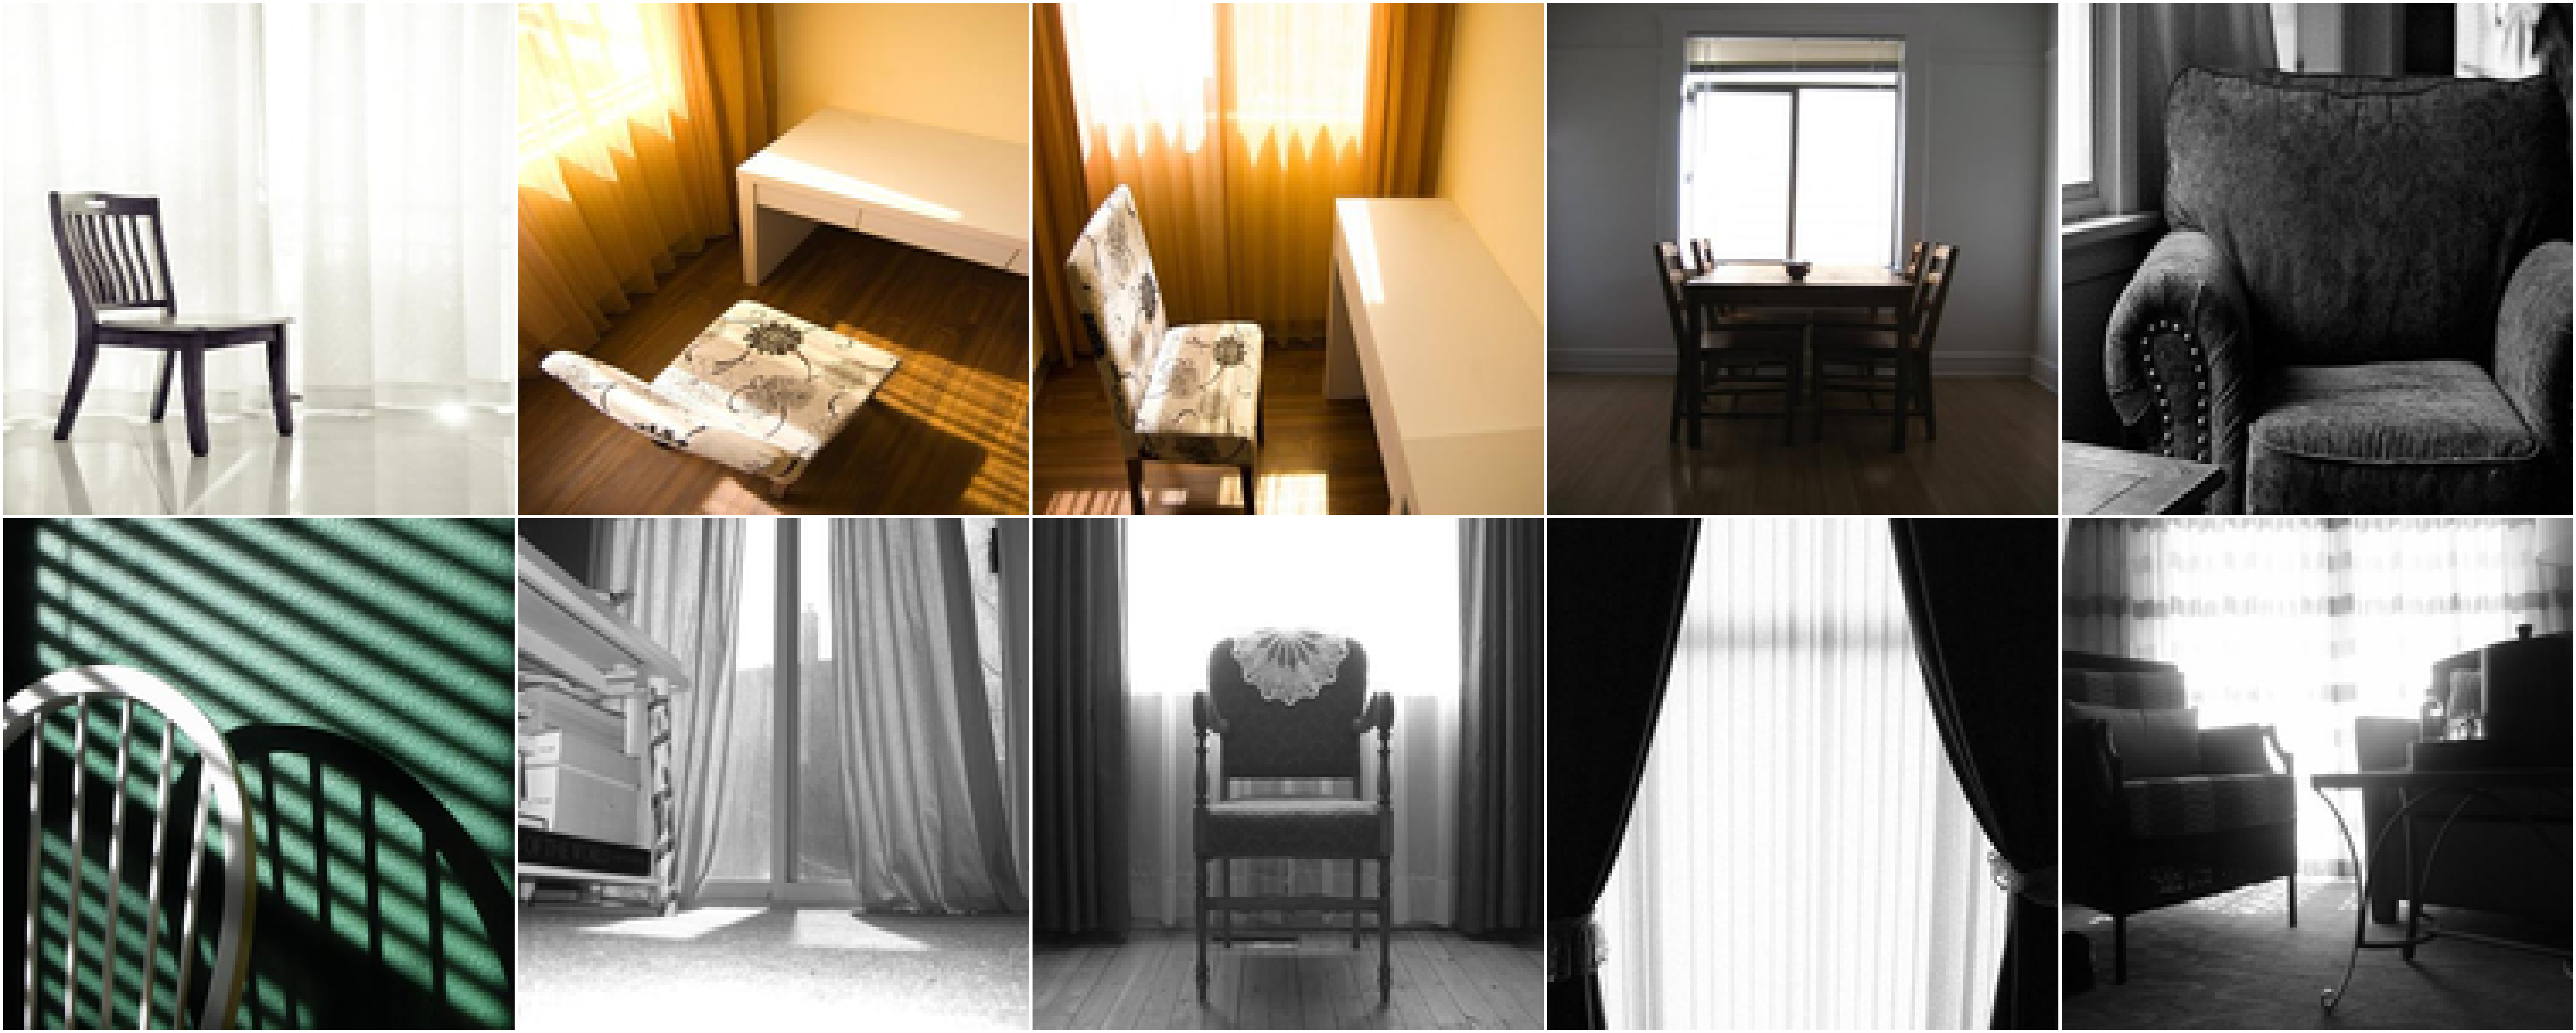

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import requests
from io import BytesIO

for img_path in similar_images:
    print(img_path)

res = []
fig = plt.figure(figsize=(100., 100.))
for path in similar_images:
    url = "https://storage.googleapis.com/vislang-public/sbu-{}".format(path)
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((150, 150), resample=Image.LANCZOS)
    res.append(img)
    
noRows = 2  
grid = ImageGrid(fig,111,
                 nrows_ncols=(noRows, k//noRows),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, res):
    ax.imshow(im)
    ax.axis('off')

_ = plt.show()

In [ ]:
# vectors = np.array(vectors)
# query = np.array(query)

import time
start_time = time.time()

# Brute force approach to check the distance between the query and each vector
distances = np.linalg.norm(vectors - features, axis=1)


K = 10  # Number of similar images to retrieve
# Get the indices of the K smallest distances
indices = np.argpartition(distances, K)[:K]
#print(len(indices))

end_time = time.time()

print("Time taken: %.4f seconds" % (end_time - start_time))